In [1]:
import mne
mne.set_log_level('error')
import matplotlib
import matplotlib.pyplot as plt
from functions import *
#tplotlib.use('TkAgg')

### Loading the data

In [2]:
# data_path = "/Users\sunnivlf\Documents/Data Set Alcohol Detector/Subjects"
data_path = "../Data Set Alcohol Detector/Subjects"
#data_path = "../Data Set Alcohol Detector/Subjects"
p_id = "/" + "sub-P019" + "/" + "ses-S002" + "/" + "sub-P019_ses-S002_task-Default_run-005"
raw = mne.io.read_raw_fif(data_path + "/" + p_id + "_eeg.fif", preload=True)

Plotting the elctrode placement on the scalp. The optimal channels for alcoholism detection are: Fp1, AF7, AF8, FC4, FC5, FC6, T7, Cz, PO7, PO8, O1, Oz. We want to look at one channel on the left side (Fp1) and one on the right side (PO8) of the scalp.

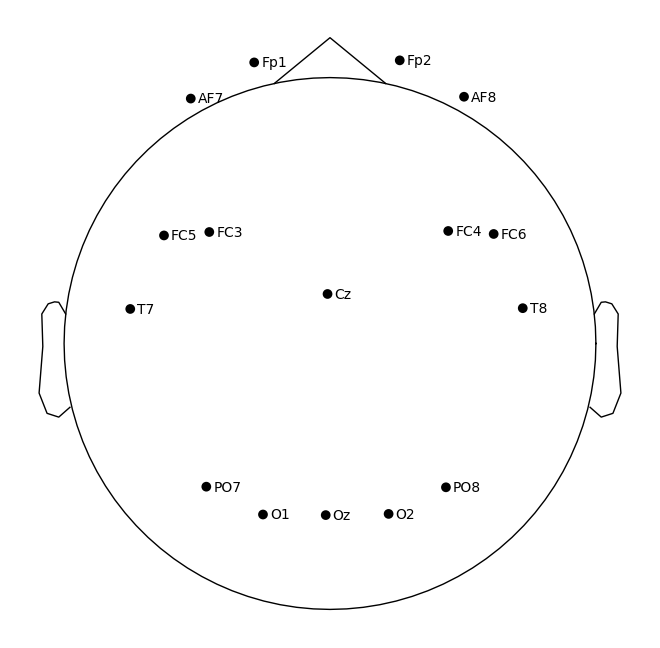

In [3]:
raw.plot_sensors(show_names=True);

### Filtering the data
Highpass filtering is included to remove drifting of the signal, while lowpass filtering will remove power line noise


/Users/kristian/miniconda3/envs/ttk7/lib/python3.8/site-packages/mne/viz/utils.py:161: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


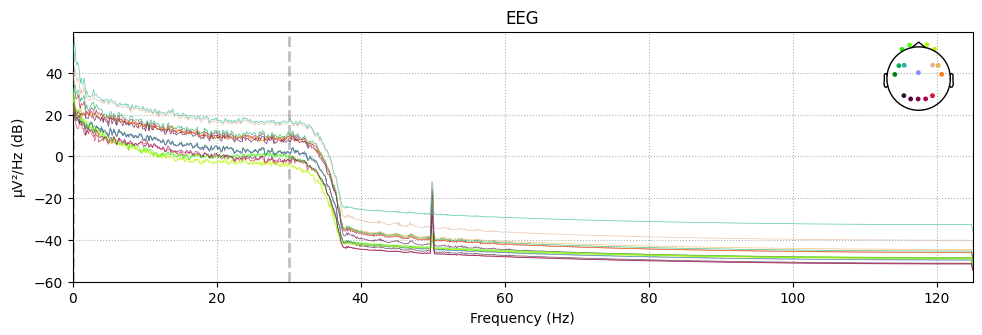

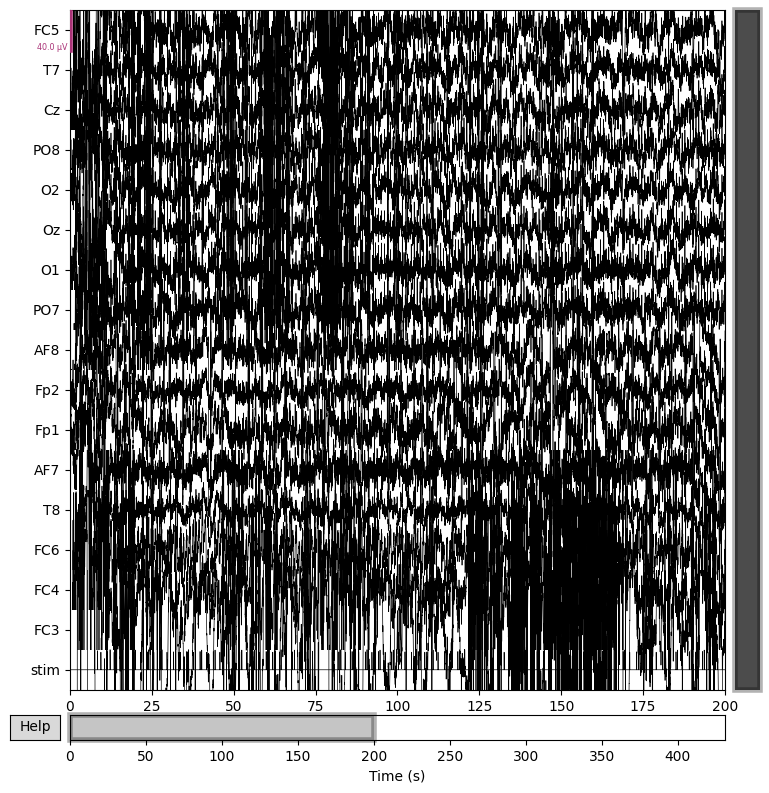

In [4]:
low_cut = 0.1 
hi_cut  = 30
raw_filt = raw.copy().filter(low_cut, hi_cut)
raw_filt.compute_psd(fmax=125).plot(picks="data", exclude="bads");
raw_filt.plot(highpass=0.1, lowpass=30, duration=200);

Choose one channel to use for this experiment. Fp2 is one of the frontal electrodes. The data and time is extracted from the filtered raw data, as numpy arrays.

In [5]:
channels = ['PO8', 'Fp1']

picks = mne.pick_channels(ch_names = raw_filt.info['ch_names'], include=channels)
data, time = raw_filt[picks, :]  

channel_nr = 1

The signal is visulaized using matplotlib.

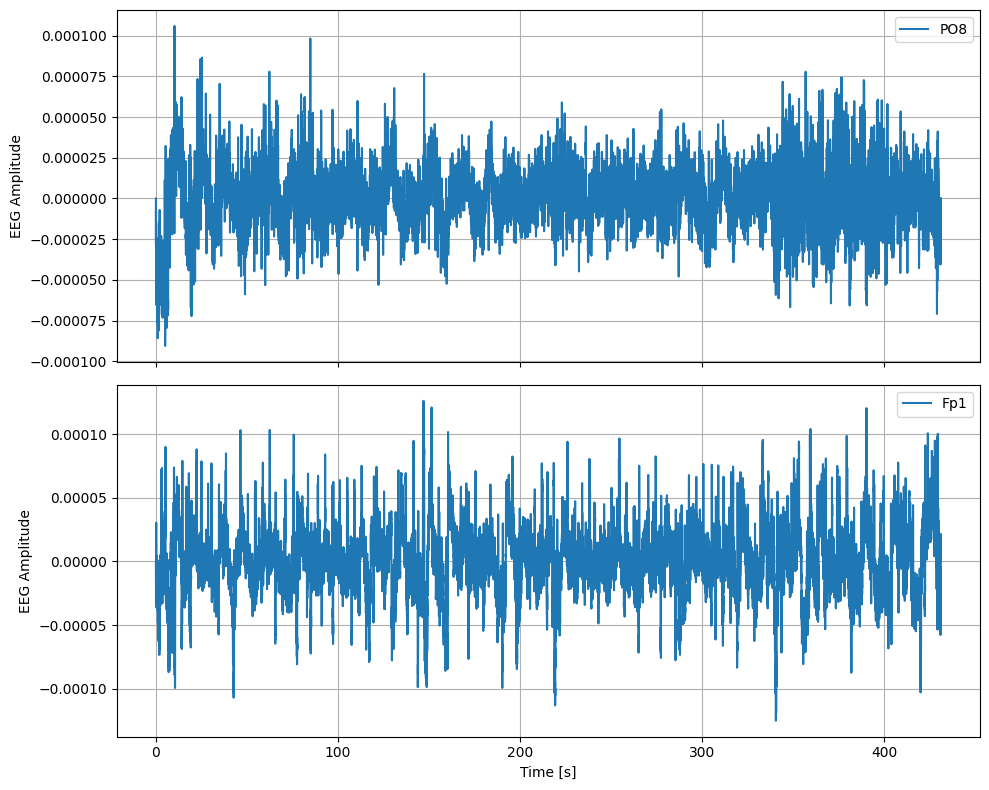

In [6]:
plt.figure(figsize=(10, 4*len(channels)))
for idx, channel in enumerate(channels):
    ax = plt.subplot(2, 1, idx+1)
    plt.plot(time, data[idx], label=channel)
    plt.ylabel('EEG Amplitude')
    plt.grid(True)
    if idx < len(channels) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Time [s]')
    plt.legend()
    # plt.ylim([-0.000110, 0.000110])
    
plt.tight_layout()
plt.show()

In [19]:
sample_rate = raw.info['sfreq']
window_size = 1

s1 = 100
s2 = s1 + window_size

delta1 = int(sample_rate*s1)
delta2 = int(sample_rate*s2)

d0 = data[0][delta1:delta2]
d1 = data[1][delta1:delta2]
t = time[delta1:delta2]
num_samples = len(d0)

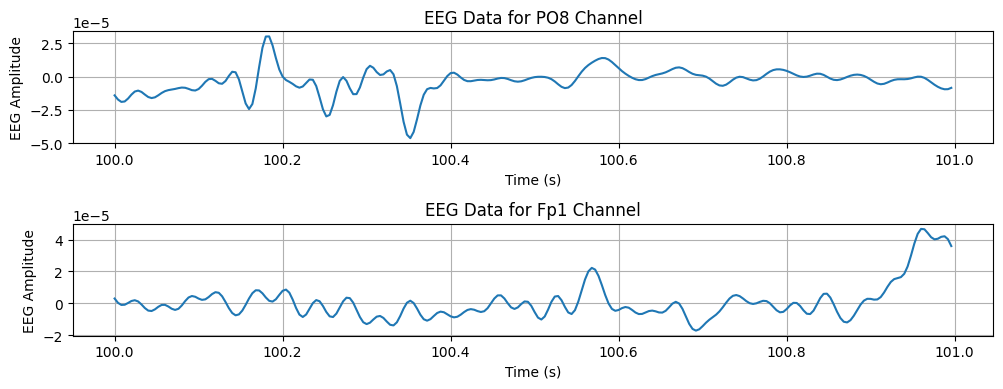

In [20]:
plt.figure(figsize=(10, 4))
plt.subplot(211)
plt.plot(t, d0)
plt.xlabel('Time (s)')
plt.ylabel('EEG Amplitude')
plt.title(f'EEG Data for {channels[0]} Channel')
plt.grid(True)

plt.subplot(212)
plt.plot(t, d1)
plt.xlabel('Time (s)')
plt.ylabel('EEG Amplitude')
plt.title(f'EEG Data for {channels[1]} Channel')
plt.grid(True)

plt.tight_layout()
plt.show()

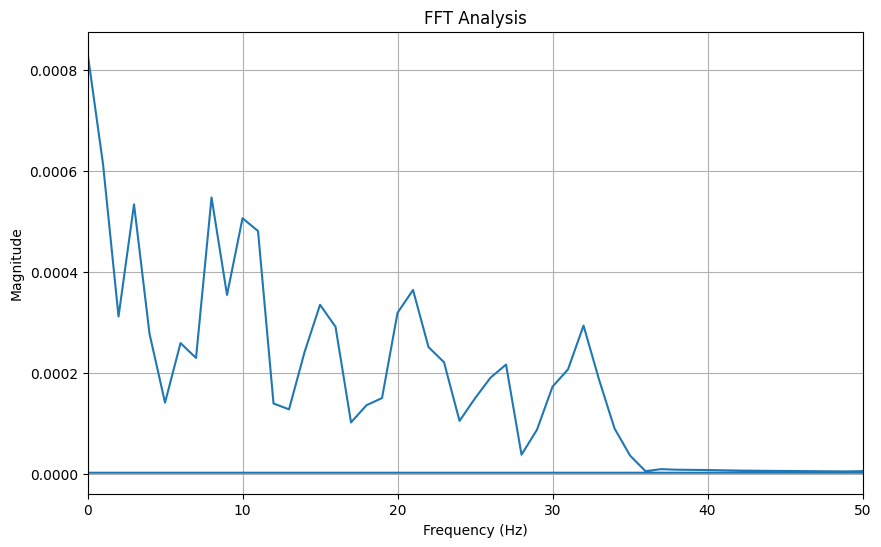

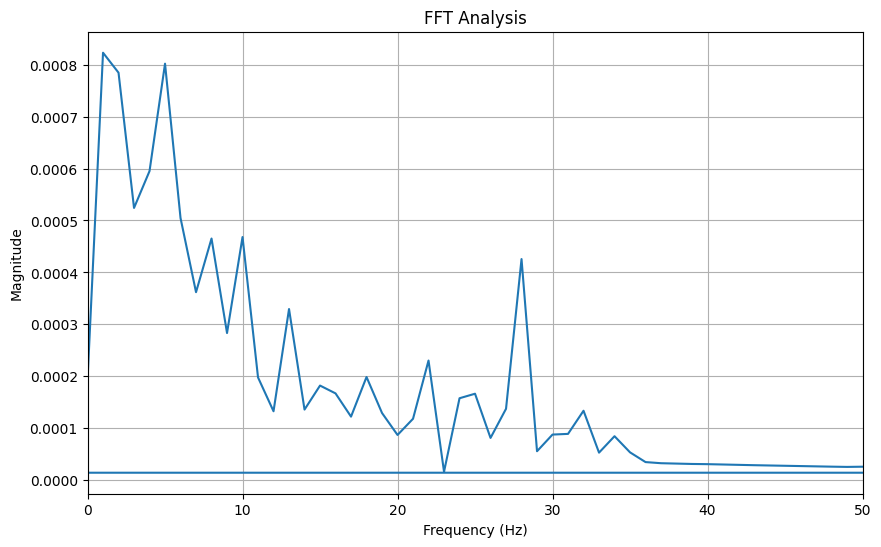

In [21]:
(freq, fft_freq) = fft(d0, num_samples, sample_rate)
(freq, fft_freq) = fft(d1, num_samples, sample_rate)

In [22]:
f, dt, ssx = plot_stft(d0, sample_rate, 50, 5)
f, dt, ssx = plot_stft(d1, sample_rate, 50, 5)

In [23]:
imfs0 = hht(t, d0, plot=False)
imfs1 = hht(t, d1, plot=False)

In [24]:
#cwtm = wt(t, d, sample_rate, w=3.0)

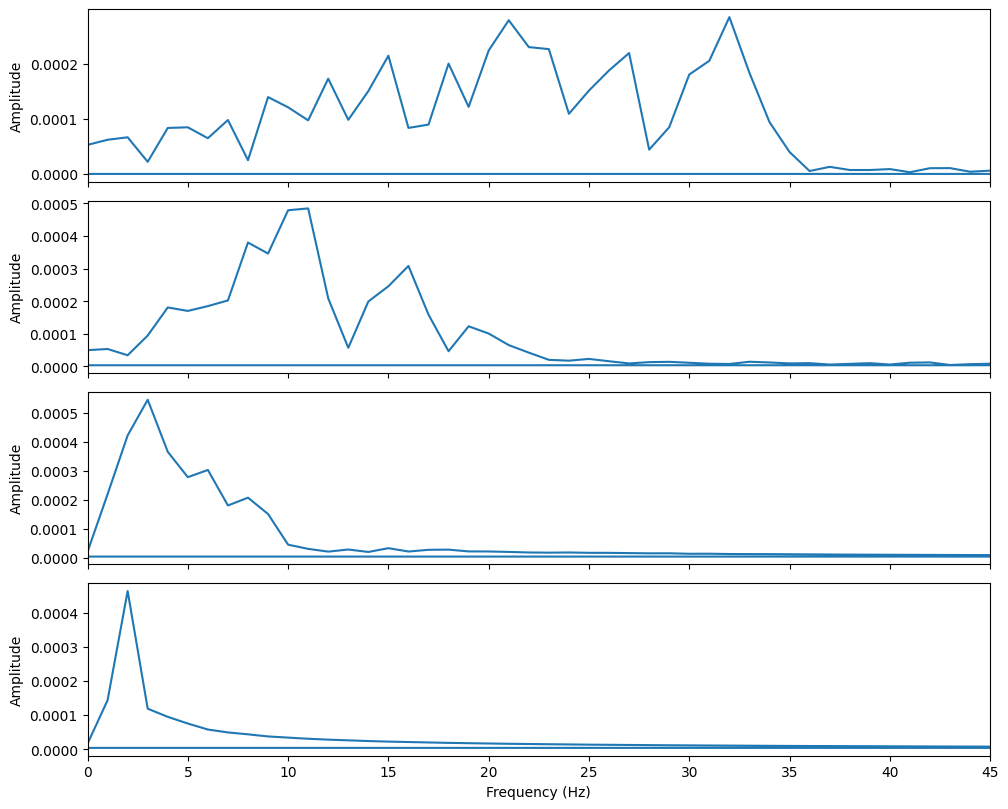

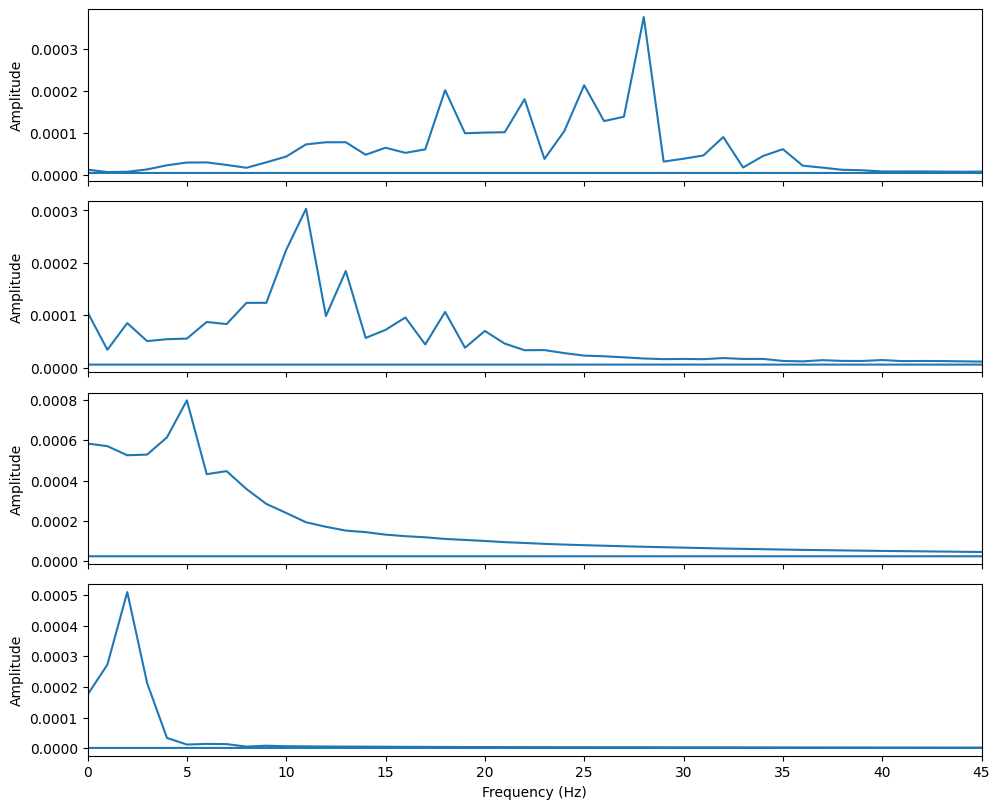

In [25]:
filt_imfs = imfs0[0:len(imfs0)-1]

# Set the figure size dynamically based on the number of IMFs
plt.figure(figsize=(10, 2*len(filt_imfs)))

for idx, imf in enumerate(filt_imfs):
    env, inst_freq = ht(t, imf, sample_rate, plot=False)
    freq, fft_res = fft(imf, num_samples, sample_rate, plot=False)
    
    ax = plt.subplot(len(filt_imfs), 1, idx+1)
    plt.plot(freq, fft_res)
    plt.xlim(0, 45)
    
    # If it's not the last subplot, remove the x-axis labels to prevent overlap
    if idx < len(filt_imfs) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Frequency (Hz)')  # Only add x-axis label to the bottom subplot

    plt.ylabel('Amplitude')

# Adjust the layout to prevent overlapping
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(bottom=0.06)
plt.show()

filt_imfs = imfs1[0:len(imfs1)-1]

# Set the figure size dynamically based on the number of IMFs
plt.figure(figsize=(10, 2*len(filt_imfs)))

for idx, imf in enumerate(filt_imfs):
    env, inst_freq = ht(t, imf, sample_rate, plot=False)
    freq, fft_res = fft(imf, num_samples, sample_rate, plot=False)
    
    ax = plt.subplot(len(filt_imfs), 1, idx+1)
    plt.plot(freq, fft_res)
    plt.xlim(0, 45)
    
    # If it's not the last subplot, remove the x-axis labels to prevent overlap
    if idx < len(filt_imfs) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Frequency (Hz)')  # Only add x-axis label to the bottom subplot

    plt.ylabel('Amplitude')

# Adjust the layout to prevent overlapping
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(bottom=0.06)
plt.show()



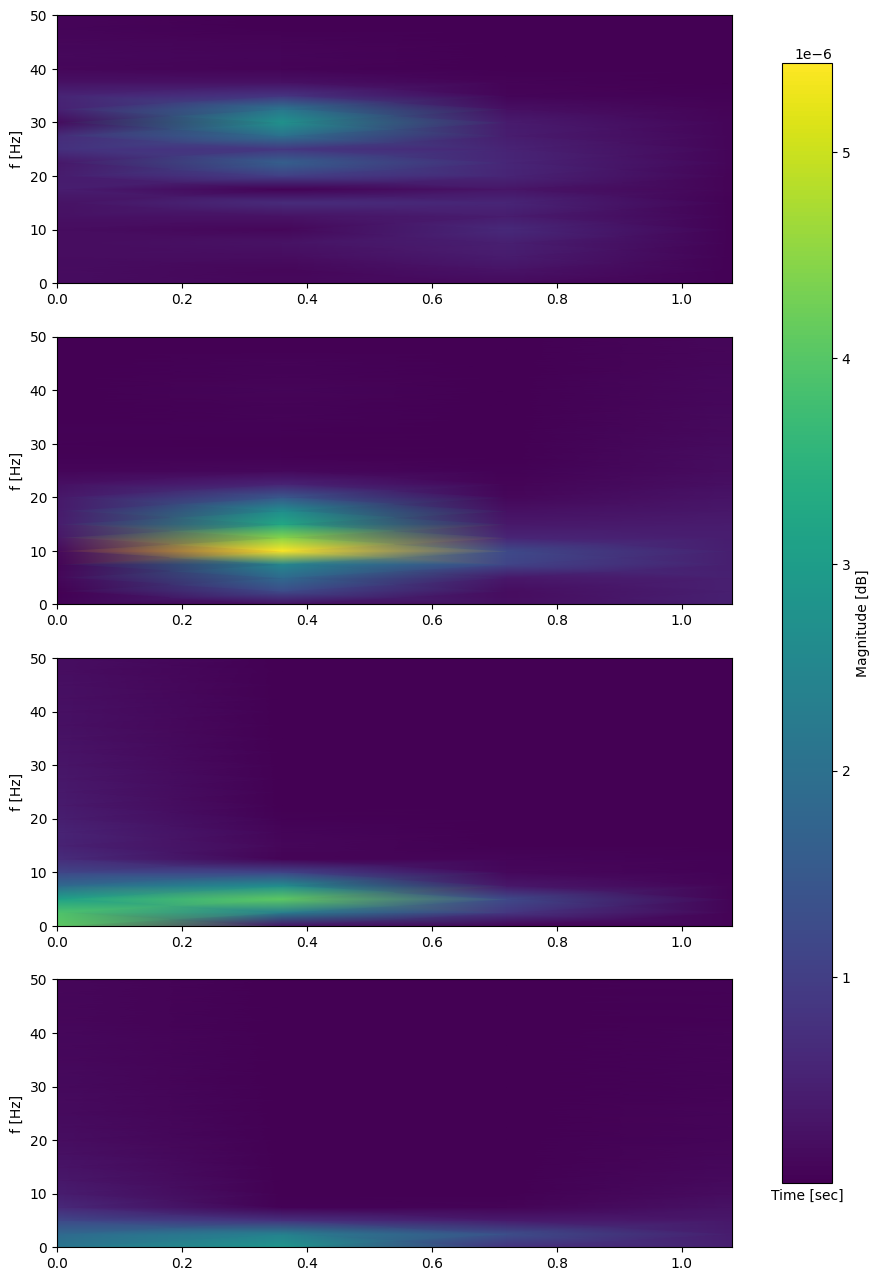

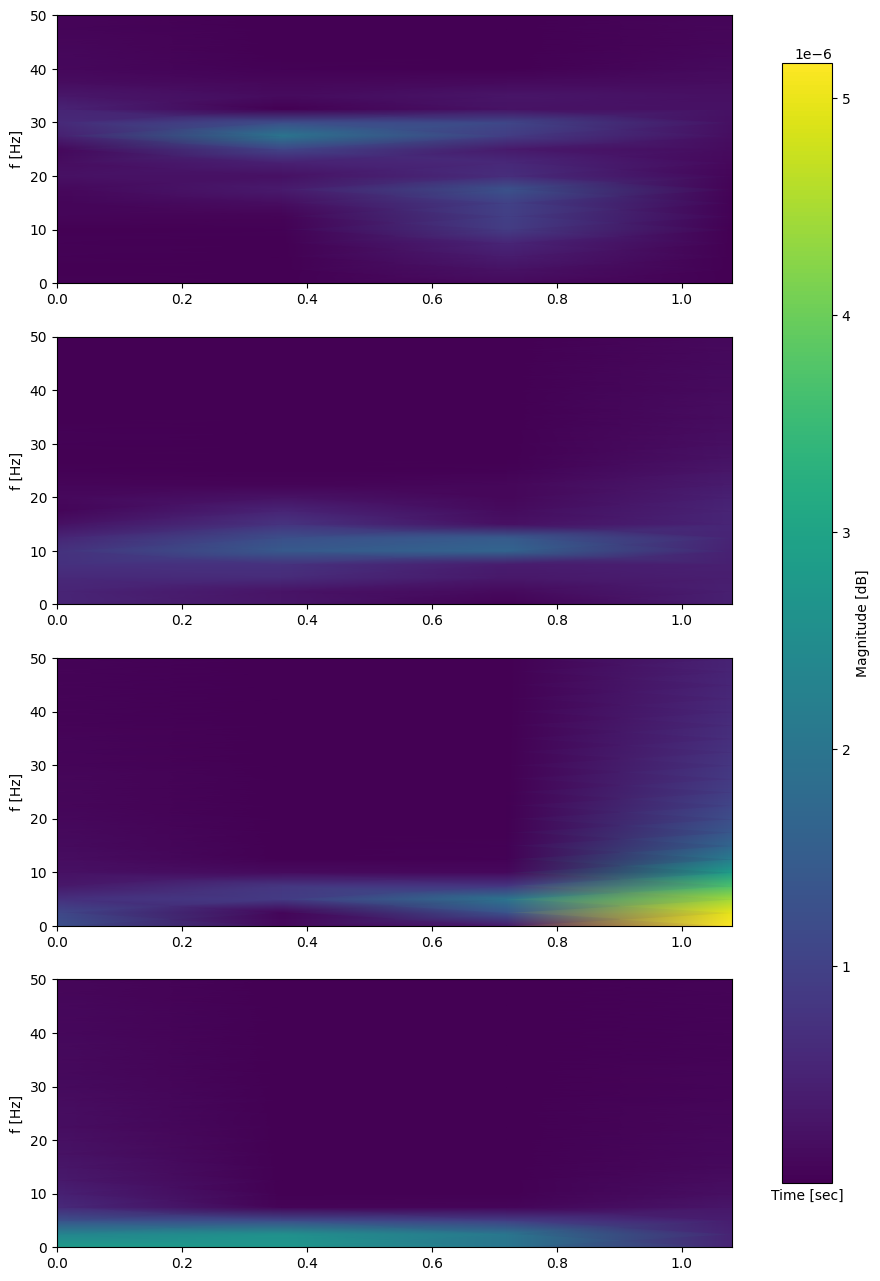

In [26]:
filt_imfs = imfs0[0:len(imfs0)-1]

# Determine global min and max values for color scale normalization
vmin = np.inf  # start with infinity
vmax = -np.inf  # start with negative infinity

for imf in filt_imfs:
    f, _, Sxx = plot_stft(imf, sample_rate=sample_rate, nperseg=100, noverlap=10, plot=False)
    vmin = min(vmin, np.abs(Sxx).min())  # update vmin
    vmax = max(vmax, np.abs(Sxx).max())  # update vmax

plt.figure(figsize=(10, 4*len(filt_imfs)))

# Create subplots and apply the same vmin and vmax to each
for idx, imf in enumerate(filt_imfs):
    f, dt, Sxx = plot_stft(imf, sample_rate=sample_rate, nperseg=100, noverlap=10, plot=False)
    plt.subplot(len(filt_imfs), 1, idx+1)
    plt.pcolormesh(dt, f, np.abs(Sxx), shading='gouraud', vmin=vmin, vmax=vmax)  # Apply the same vmin and vmax
    plt.ylabel('f [Hz]')
    plt.ylim([0, 50])

# After creating all subplots, add a single colorbar to the figure
plt.subplots_adjust(right=0.8)  # Adjust subplot to not overlap with colorbar
cbar_ax = plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7])  # Position for the colorbar
plt.colorbar(cax=cbar_ax, label='Magnitude [dB]')

# Add common xlabel
plt.xlabel('Time [sec]')

plt.show()

filt_imfs = imfs1[0:len(imfs1)-1]

# Determine global min and max values for color scale normalization
vmin = np.inf  # start with infinity
vmax = -np.inf  # start with negative infinity

for imf in filt_imfs:
    f, _, Sxx = plot_stft(imf, sample_rate=sample_rate, nperseg=100, noverlap=10, plot=False)
    vmin = min(vmin, np.abs(Sxx).min())  # update vmin
    vmax = max(vmax, np.abs(Sxx).max())  # update vmax

plt.figure(figsize=(10, 4*len(filt_imfs)))

# Create subplots and apply the same vmin and vmax to each
for idx, imf in enumerate(filt_imfs):
    f, dt, Sxx = plot_stft(imf, sample_rate=sample_rate, nperseg=100, noverlap=10, plot=False)
    plt.subplot(len(filt_imfs), 1, idx+1)
    plt.pcolormesh(dt, f, np.abs(Sxx), shading='gouraud', vmin=vmin, vmax=vmax)  # Apply the same vmin and vmax
    plt.ylabel('f [Hz]')
    plt.ylim([0, 50])

# After creating all subplots, add a single colorbar to the figure
plt.subplots_adjust(right=0.8)  # Adjust subplot to not overlap with colorbar
cbar_ax = plt.gcf().add_axes([0.85, 0.15, 0.05, 0.7])  # Position for the colorbar
plt.colorbar(cax=cbar_ax, label='Magnitude [dB]')

# Add common xlabel
plt.xlabel('Time [sec]')

plt.show()

### Plot Wavelet transform

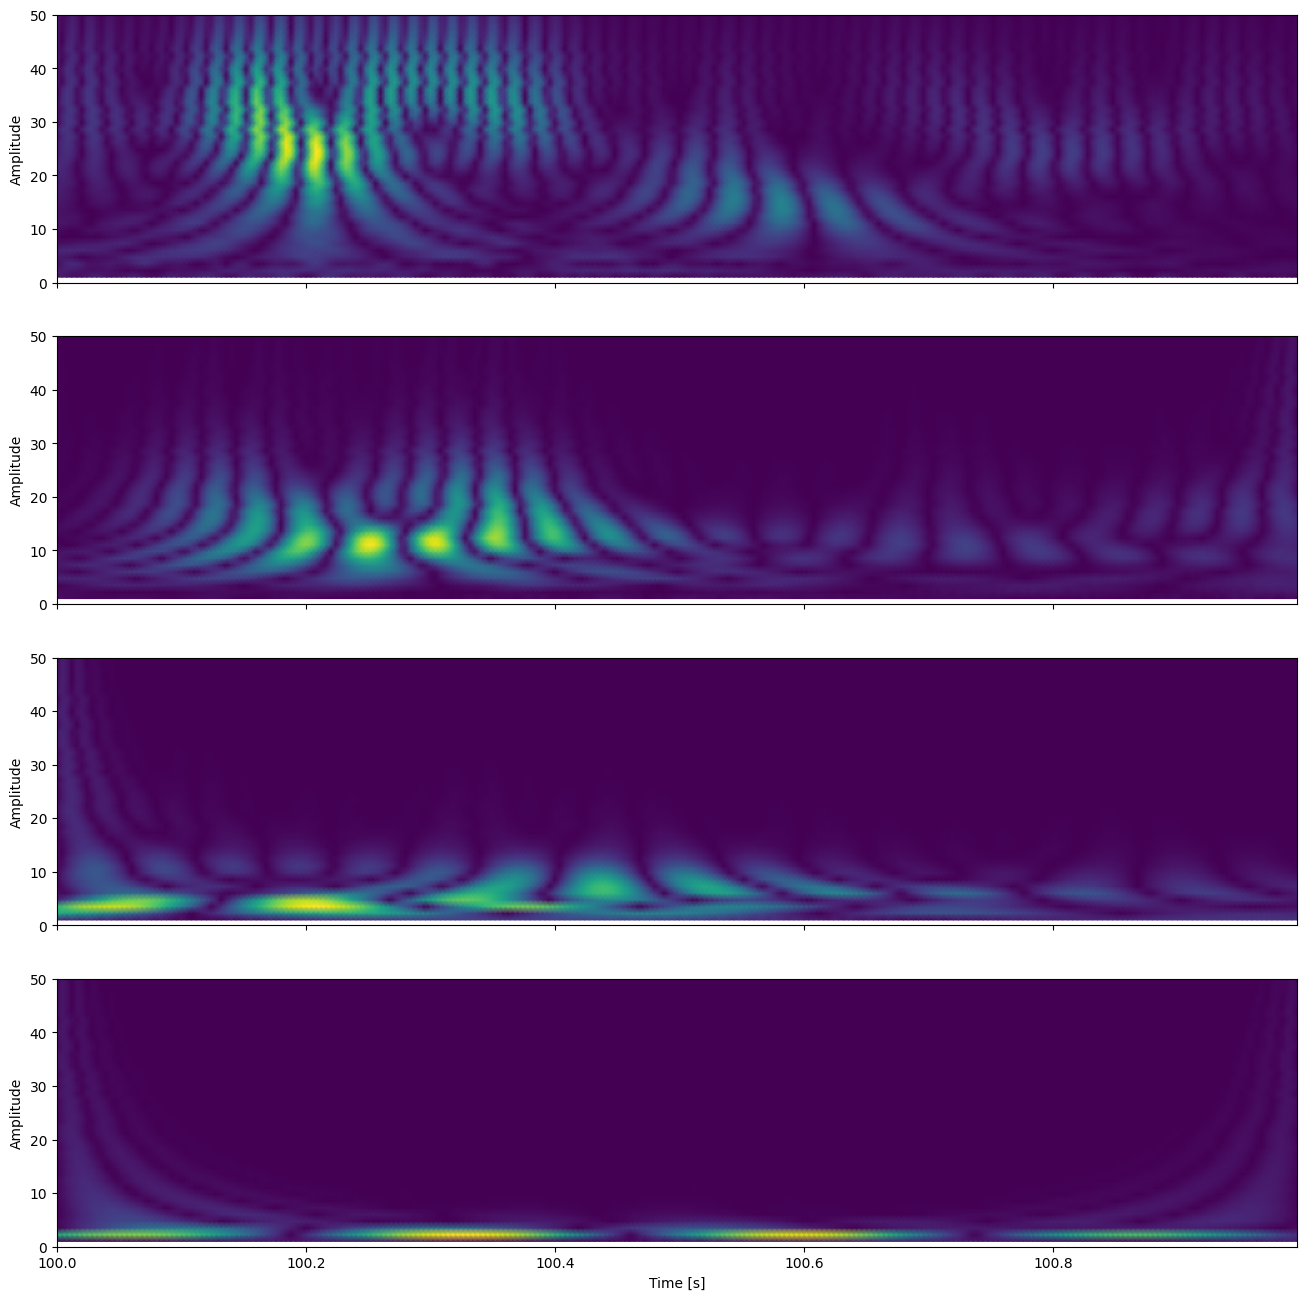

In [27]:
filt_imfs = imfs0[0:len(imfs0)-1]

plt.figure(figsize=(16, 4*len(filt_imfs)))
# Create subplots and apply the same vmin and vmax to each
for idx, imf in enumerate(filt_imfs):
    cwtm = wt(t, imf, sample_rate, w=6.0)
    ax = plt.subplot(len(filt_imfs), 1, idx+1)
    freq = np.linspace(1, sample_rate/2, 100)
    plt.pcolormesh(t, freq, np.abs(cwtm), cmap='viridis', shading='gouraud')
    if idx < len(filt_imfs) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Time [s]')  # Only add x-axis label to the bottom subplot
    plt.ylabel('Amplitude')
    plt.ylim([0, 50])
plt.show()

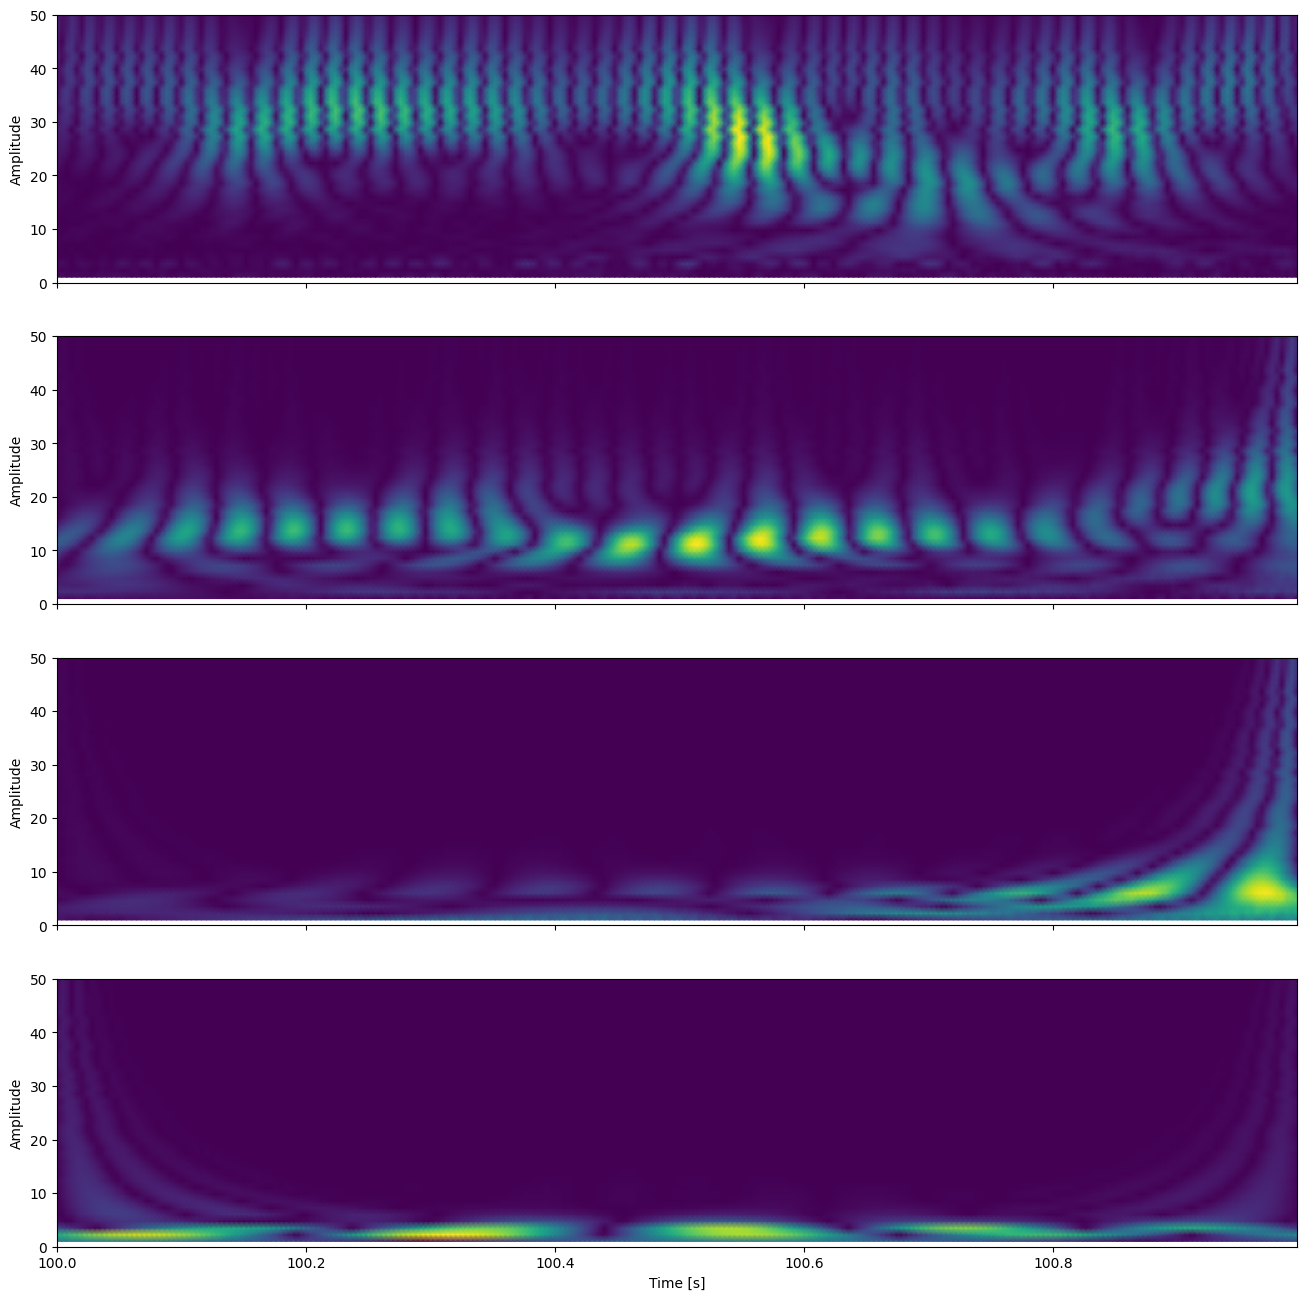

In [28]:
filt_imfs = imfs1[0:len(imfs1)-1]

plt.figure(figsize=(16, 4*len(filt_imfs)))
# Create subplots and apply the same vmin and vmax to each
for idx, imf in enumerate(filt_imfs):
    cwtm = wt(t, imf, sample_rate, w=6.0)
    ax = plt.subplot(len(filt_imfs), 1, idx+1)
    freq = np.linspace(1, sample_rate/2, 100)
    plt.pcolormesh(t, freq, np.abs(cwtm), cmap='viridis', shading='gouraud')
    if idx < len(filt_imfs) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Time [s]')  # Only add x-axis label to the bottom subplot
    plt.ylabel('Amplitude')
    plt.ylim([0, 50])
plt.show()

### Plot Hilbert Transform

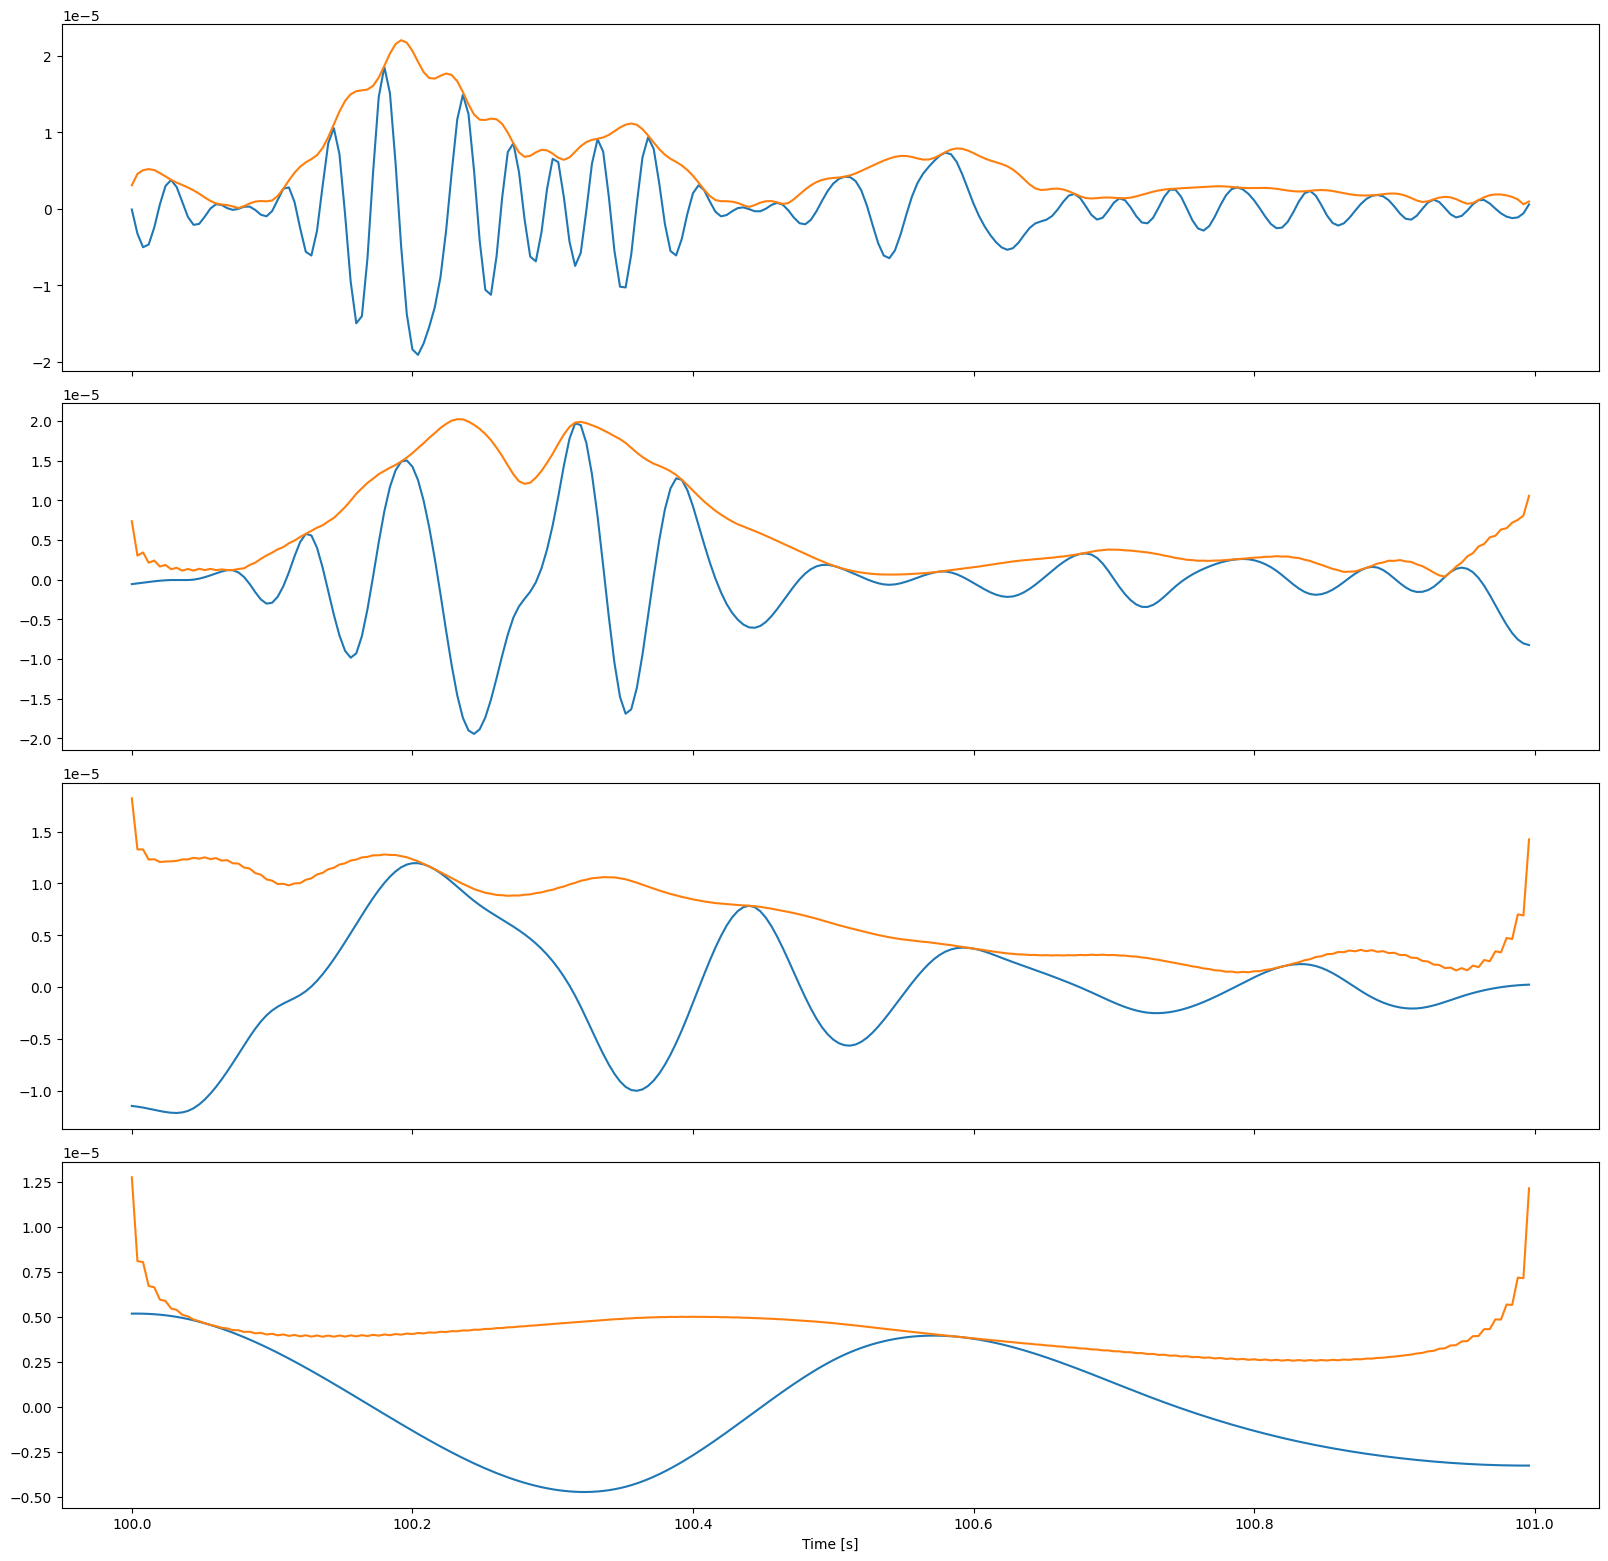

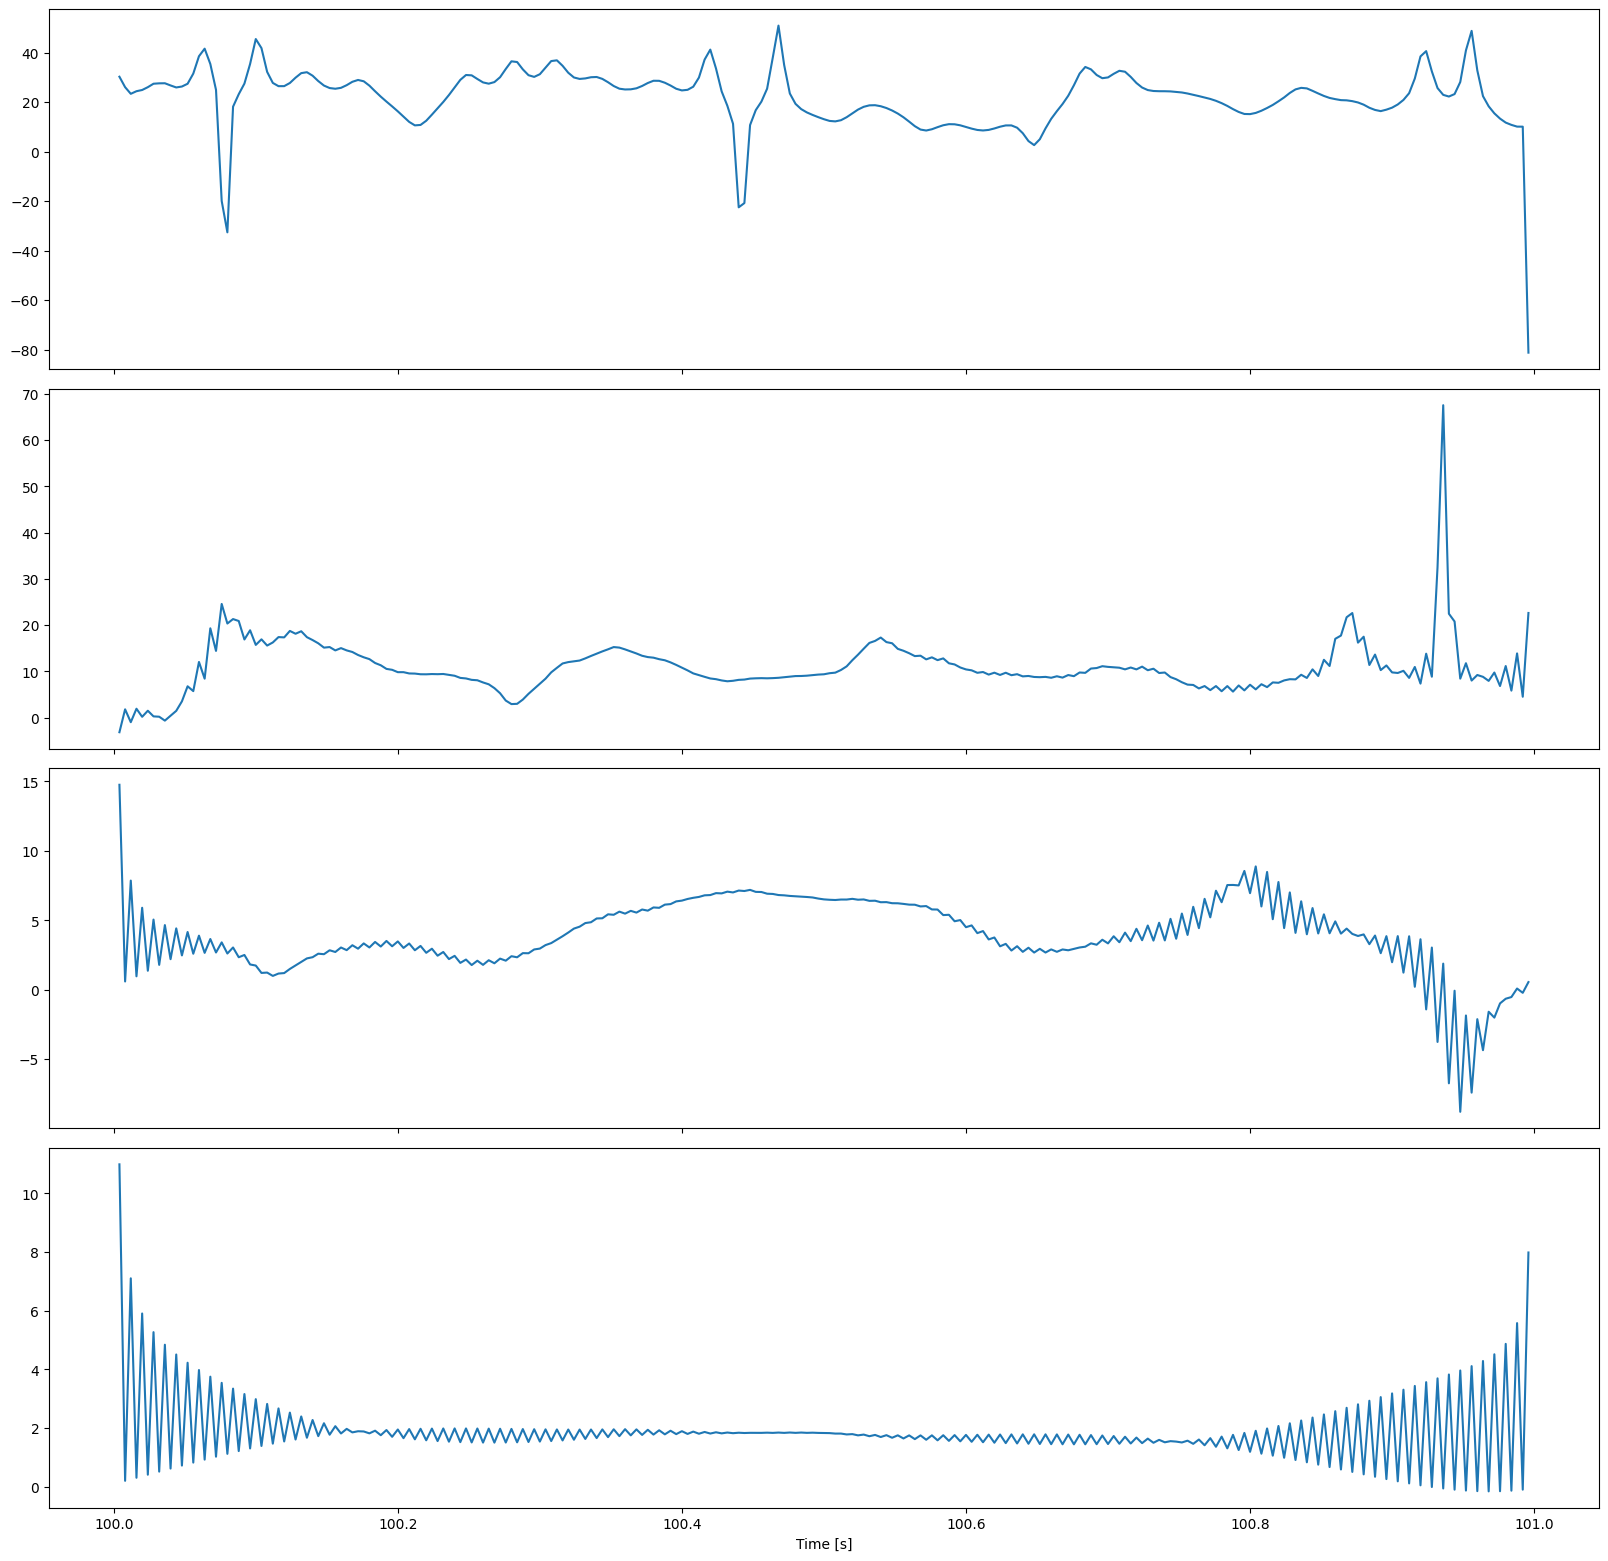

In [29]:
filt_imfs = imfs0[0:len(imfs0)-1]

envelopes = []
frequencies = []
for idx, imf in enumerate(filt_imfs):
    amplitude_envelope, instantaneous_frequency = ht(t, imf, sample_rate, plot=False)
    envelopes.append(amplitude_envelope)
    frequencies.append(instantaneous_frequency)

plt.figure(figsize=(16, 4*len(filt_imfs)))
for idx, envelope in enumerate(envelopes):
    ax = plt.subplot(len(filt_imfs), 1, idx+1)
    plt.plot(t, filt_imfs[idx], label=f'IMF {idx}')
    plt.plot(t, envelope)    
    if idx < len(filt_imfs) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Time [s]')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(bottom=0.06)
plt.show()

plt.figure(figsize=(16, 4*len(filt_imfs)))
for idx, frequency in enumerate(frequencies):
    ax = plt.subplot(len(filt_imfs), 1, idx+1)
    plt.plot(t[1:], frequency, label=f'IMF {idx}')    
    if idx < len(filt_imfs) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Time [s]')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(bottom=0.06)
plt.show()

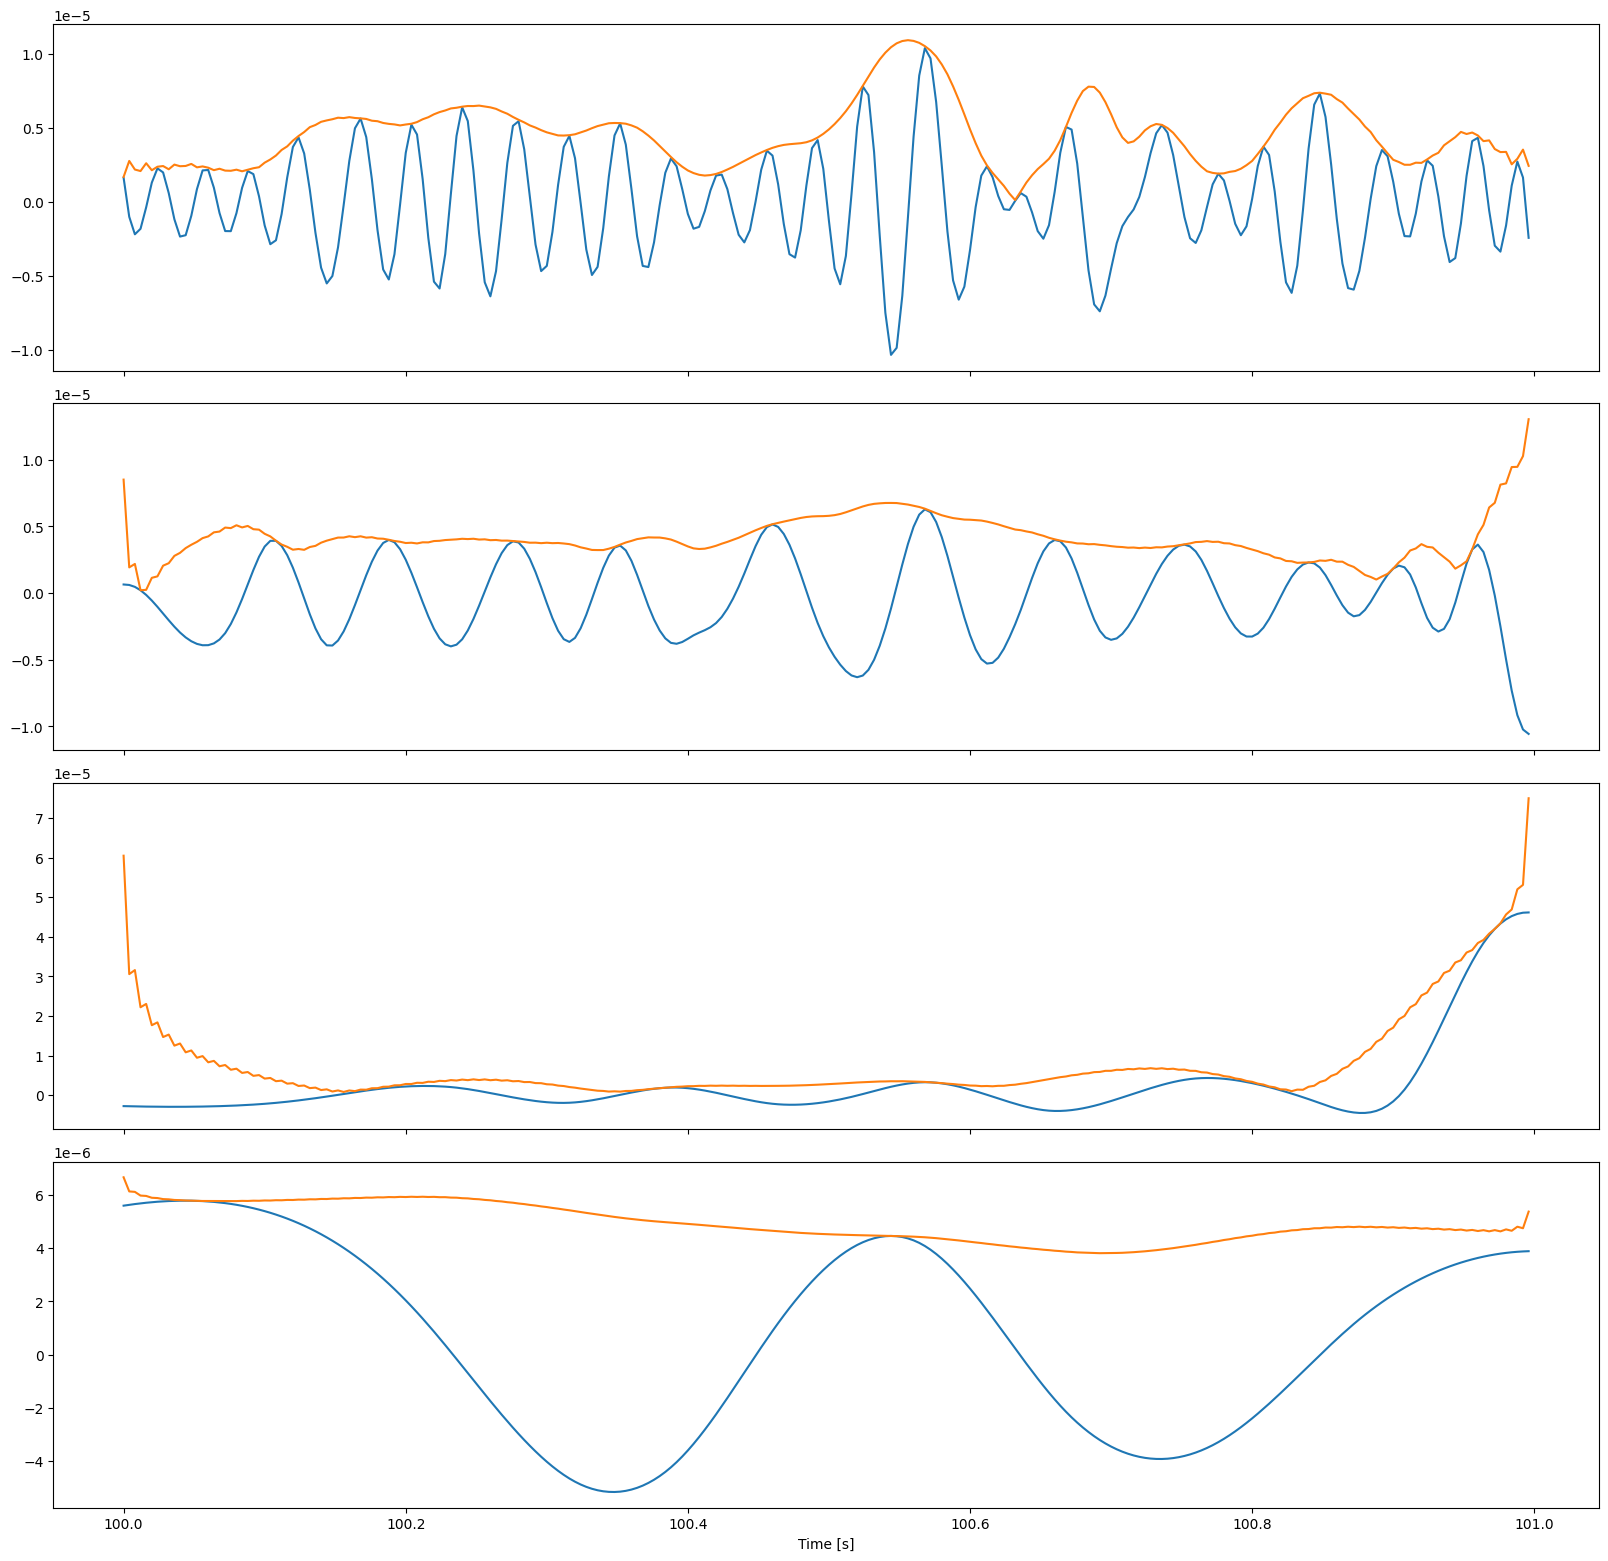

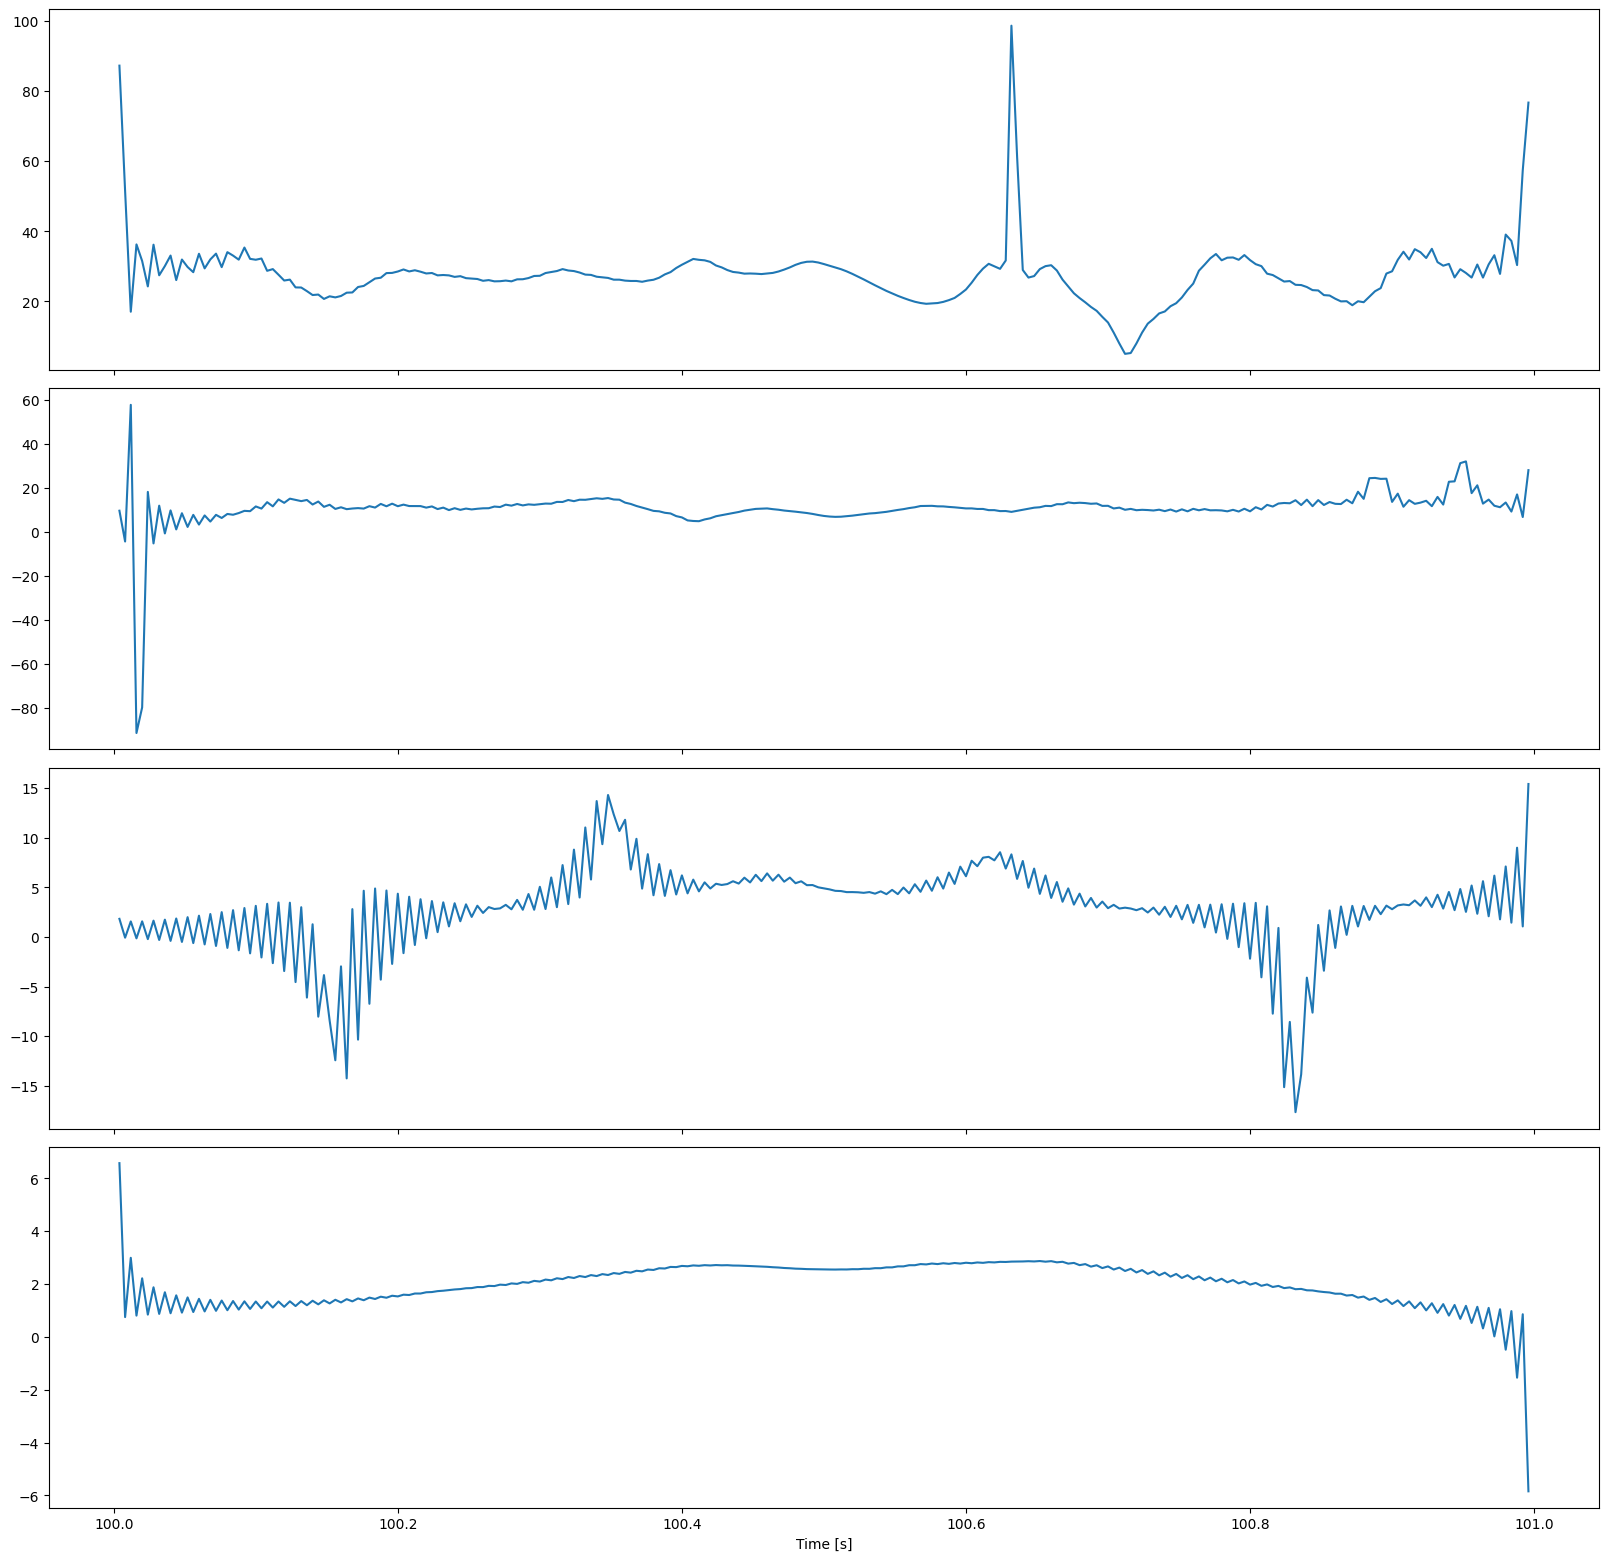

In [30]:
filt_imfs = imfs1[0:len(imfs1)-1]

envelopes = []
frequencies = []
for idx, imf in enumerate(filt_imfs):
    amplitude_envelope, instantaneous_frequency = ht(t, imf, sample_rate, plot=False)
    envelopes.append(amplitude_envelope)
    frequencies.append(instantaneous_frequency)

plt.figure(figsize=(16, 4*len(filt_imfs)))
for idx, envelope in enumerate(envelopes):
    ax = plt.subplot(len(filt_imfs), 1, idx+1)
    plt.plot(t, filt_imfs[idx], label=f'IMF {idx}')
    plt.plot(t, envelope)    
    if idx < len(filt_imfs) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Time [s]')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(bottom=0.06)
plt.show()

plt.figure(figsize=(16, 4*len(filt_imfs)))
for idx, frequency in enumerate(frequencies):
    ax = plt.subplot(len(filt_imfs), 1, idx+1)
    plt.plot(t[1:], frequency, label=f'IMF {idx}')    
    if idx < len(filt_imfs) - 1:
        ax.set_xticklabels([])
    else:
        plt.xlabel('Time [s]')
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.subplots_adjust(bottom=0.06)
plt.show()